In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data8205


In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. All changes under this directory will be kept even after reset. Please clean unnecessary files in time to speed up environment loading.
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, you need to use the persistence path as the following:
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
     |████████████████████████████████| 122kB 9.6MB/s eta 0:00:01


In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可:
# Also add the following code, so that every time the environment (kernel) starts, just run the following code:
import sys
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [ ]:
!conda install -n python35-paddle120-env tensorflow-gpu --yes

<h1 align="center">基于 PaddlePaddle 框架的人脸识别</h1>

## 1 数据预处理

### 1.1 图像爬取

In [ ]:
from selenium import webdriver
import time
import urllib.request
import os

# 存图位置
local_path = 'downloads/jw' # 修改路径
# 爬取页面网址，建议使用搜狗图片
url = 'https://pic.sogou.com/pics?query=%BD%AA%CE%C4&w=05009900&p=&_asf=pic.sogou.com&_ast=1589590575&sc=index&sut=3006&sst0=1589590574809'
# 元素的xpath
xpath = '//div[@id="imgid"]/ul/li/a/img'
# 启动chrome浏览器
chromeDriver = r'D:/BJTU/AI/Lab/Lab1/chromedriver.exe'
driver = webdriver.Chrome(chromeDriver)

# 最大化窗口，因为每一次爬取只能看到视图内的图片
driver.maximize_window()

# 记录下载过的图片网址，避免重复下载
img_url_dic = {}

# 浏览器打开爬取页面
driver.get(url)

# 模拟滚动视图浏览更多图片
pos = 0
m = 0  # 图片编号
for i in range(100):
    pos += i * 500  # 每次下滚500
    js = "document.documentElement.scrollTop=%d" % pos
    driver.execute_script(js)
    time.sleep(1)

    for element in driver.find_elements_by_xpath(xpath):
        try:
            img_url = element.get_attribute('src')

            # 保存图片到指定路径
            if img_url != None and not img_url in img_url_dic:
                img_url_dic[img_url] = ''
                m += 1
                # print(img_url)
                ext = img_url.split('/')[-1]
                # print(ext)
                filename = str(m) + '.jpg'
                print(filename)

                # 保存图片
                urllib.request.urlretrieve(img_url, os.path.join(local_path, filename))

        except OSError:
            print('Occur OSError!')
            print(pos)
            break

driver.close()


### 1.2 通过 OpenCV 拍照

In [ ]:
import cv2
import os

print("=============================================")
print("=  热键(请在摄像头的窗口使用)：             =")
print("=  z: 更改存储目录                          =")
print("=  x: 拍摄图片                              =")
print("=  q: 退出                                  =")
print("=============================================")
print()
class_name = input("请输入存储目录：")
while os.path.exists(class_name):
    class_name = input("目录已存在！请输入存储目录：")
os.mkdir(class_name)

index = 1
cap = cv2.VideoCapture(0)
width = 640
height = 480
w = 360
cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)

crop_w_start = (width - w) // 2
crop_h_start = (height - w) // 2

print(width, height)

while True:
    # get a frame
    ret, frame = cap.read()
    # show a frame
    frame = frame[crop_h_start:crop_h_start + w, crop_w_start:crop_w_start + w]
    frame = cv2.flip(frame, 1, dst=None)
    cv2.imshow("capture", frame)

    input = cv2.waitKey(1) & 0xFF

    if input == ord('z'):
        class_name = input("请输入存储目录：")
        while os.path.exists(class_name):
            class_name = input("目录已存在！请输入存储目录：")
        os.mkdir(class_name)
    elif input == ord('x'):
        cv2.imwrite("%s/%d.jpeg" % (class_name, index),
                    cv2.resize(frame, (224, 224), interpolation=cv2.INTER_AREA))
        print("%s: %d 张图片" % (class_name, index))
        index += 1
    if input == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### 1.3 处理获取的图像

In [ ]:
# -*-coding:utf8-*-
import os
import cv2
import time
import shutil


def getAllPath(dirpath, *suffix):
    PathArray = []
    for r, ds, fs in os.walk(dirpath):
        for fn in fs:
            if os.path.splitext(fn)[1] in suffix:
                fname = os.path.join(r, fn)
                PathArray.append(fname)
    return PathArray


# 从源路径中读取所有图片放入一个list，然后逐一进行检查，把其中的脸扣下来，存储到目标路径中
def readPicSaveFace(sourcePath, targetPath, invalidPath, *suffix):
    try:
        ImagePaths = getAllPath(sourcePath, *suffix)

        # 对list中图片逐一进行检查,找出其中的人脸然后写到目标文件夹下
        count = 1
        # haarcascade_frontalface_alt.xml为库训练好的分类器文件，下载opencv，安装目录中可找到
        face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        for imagePath in ImagePaths:
            img = cv2.imread(imagePath)
            if type(img) != str:
                faces = face_cascade.detectMultiScale(img, 1.1, 5)
                if len(faces):
                    for (x, y, w, h) in faces:
                        # 设置人脸宽度大于128像素，去除较小的人脸
                        if w >= 50 and h >= 50:
                            # 以时间戳和读取的排序作为文件名称
                            listStr = [str(int(time.time())), str(count)]
                            fileName = ''.join(listStr)
                            # 扩大图片，可根据坐标调整
                            X = int(x)
                            W = min(int((x + w) ), img.shape[1])
                            Y = int(y)
                            H = min(int((y + h)), img.shape[0])

                            f = cv2.resize(img[Y:H, X:W], (W - X, H - Y))
                            cv2.imwrite(targetPath + os.sep + '%s.jpg' % fileName, f)
                            count += 1
                            print(imagePath + " have face")
                else:
                    shutil.move(imagePath, invalidPath)
    except IOError:
        print("Error")

    else:
        print('Find ' + str(count - 1) + ' faces to Destination ' + targetPath)


if __name__ == '__main__':
    invalidPath = 'downloads/npface' 
    sourcePath = 'downloads/tq' # 源路径
    targetPath = 'image/tq' # 目标路径
    readPicSaveFace(sourcePath, targetPath, invalidPath, '.jpg', '.JPG', 'png', 'PNG','.jpeg') # 图片格式

In [ ]:
!unzip -o /home/aistudio/data/data8205/new_images.zip -d  /home/aistudio/

Archive:  /home/aistudio/data/data8205/new_images.zip
   creating: /home/aistudio/images/face/dilireba/
  inflating: /home/aistudio/images/face/dilireba/15916901692.jpg  
  inflating: /home/aistudio/images/face/dilireba/15916901693.jpg  
  inflating: /home/aistudio/images/face/dilireba/15916901694.jpg  
  inflating: /home/aistudio/images/face/dilireba/15916901695.jpg  
  inflating: /home/aistudio/images/face/dilireba/15916901696.jpg  
  inflating: /home/aistudio/images/face/dilireba/159169017012.jpg  
  inflating: /home/aistudio/images/face/dilireba/159169017016.jpg  
  inflating: /home/aistudio/images/face/dilireba/159169017017.jpg  
  inflating: /home/aistudio/images/face/dilireba/159169017019.jpg  
  inflating: /home/aistudio/images/face/dilireba/159169017020.jpg  
  inflating: /home/aistudio/images/face/dilireba/159169017021.jpg  
  inflating: /home/aistudio/images/face/dilireba/159169017125.jpg  
  inflating: /home/aistudio/images/face/dilireba/159169017126.jpg  
  inflating: /hom

In [ ]:
!ls /home/aistudio/images/face
!ls /home/aistudio/face/
!ls /home/aistudio/data

dilireba  jiangwen  pengyuyan  tangqi  zhangziyi  zhengkai
readme.json  test.list	trainer.list
data8205


### 1.4 生成训练集和测试集

In [3]:
import os
import json

# 设置要生成文件的路径
data_root_path = '/home/aistudio/images/face'
# 所有类别的信息
class_detail = []
# 获取所有类别保存的文件夹名称
class_dirs = os.listdir(data_root_path)
# 类别标签
class_label = 0
# 获取总类别的名称
father_paths = data_root_path.split('/')    #['', 'home', 'aistudio', 'images', 'face']
while True:
    if father_paths[father_paths.__len__() - 1] == '':
        del father_paths[father_paths.__len__() - 1]
    else:
        break
father_path = father_paths[father_paths.__len__() - 1]
# 把生产的数据列表都放在自己的总类别文件夹中
data_list_path = '/home/aistudio/%s/' % father_path
# 如果不存在这个文件夹,就创建
isexist = os.path.exists(data_list_path)
if not isexist:
    os.makedirs(data_list_path)
# 清空原来的数据
with open(data_list_path + "test.list", 'w') as f:
    pass
with open(data_list_path + "trainer.list", 'w') as f:
    pass
# 总的图像数量
all_class_images = 0
# 读取每个类别
for class_dir in class_dirs:
    # 每个类别的信息
    class_detail_list = {}
    test_sum = 0
    trainer_sum = 0
    # 统计每个类别有多少张图片
    class_sum = 0
    # 获取类别路径
    path = data_root_path + "/" + class_dir
    # 获取所有图片
    img_paths = os.listdir(path)

    for img_path in img_paths:                                  # 遍历文件夹下的每个图片
        name_path = path + '/' + img_path                       # 每张图片的路径
        if class_sum % 10 == 0:                                 # 每10张图片取一个做测试数据
            test_sum += 1                                       #test_sum测试数据的数目
            with open(data_list_path + "test.list", 'a') as f:
                f.write(name_path + "\t%d" % class_label + "\n") #class_label 标签：0,1,2
        else:
            trainer_sum += 1                                    #trainer_sum测试数据的数目
            with open(data_list_path + "trainer.list", 'a') as f:
                f.write(name_path + "\t%d" % class_label + "\n")#class_label 标签：0,1,2
        class_sum += 1                                          #每类图片的数目
        all_class_images += 1                                   #所有类图片的数目

    # 说明的json文件的class_detail数据
    class_detail_list['class_name'] = class_dir             #类别名称，如jiangwen
    class_detail_list['class_label'] = class_label          #类别标签，0,1,2
    class_detail_list['class_test_images'] = test_sum       #该类数据的测试集数目
    class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
    class_detail.append(class_detail_list)         
    class_label += 1                                            #class_label 标签：0,1,2
# 获取类别数量
all_class_sum = class_dirs.__len__()
# 说明的json文件信息
readjson = {}
readjson['all_class_name'] = father_path                  #文件父目录
readjson['all_class_sum'] = all_class_sum                #
readjson['all_class_images'] = all_class_images
readjson['class_detail'] = class_detail
jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
with open(data_list_path + "readme.json",'w') as f:
    f.write(jsons)
print ('生成数据列表完成！')


生成数据列表完成！


In [4]:
#导入要用到的模块
import paddle
import paddle.fluid as fluid
import numpy
import os
import sys
import math
from multiprocessing import cpu_count
import matplotlib.pyplot as plt

## 2 数据加载

In [5]:
# 定义训练的mapper
# train_mapper函数的作用是用来对训练集的图像进行处理修剪和数组变换，返回img数组和标签 
# sample是一个python元组，里面保存着图片的地址和标签。 ('../images/face/zhangziyi/20181206145348.png', 2)
def train_mapper(sample):
    img, label = sample
    # 进行图片的读取，由于数据集的像素维度各不相同，需要进一步处理对图像进行变换
    img = paddle.dataset.image.load_image(img)       
    #进行了简单的图像变换，这里对图像进行crop修剪操作，输出img的维度为(3, 100, 100)
    img = paddle.dataset.image.simple_transform(im=img,          #输入图片是HWC   
                                                resize_size=100, # 剪裁图片
                                                crop_size=100, 
                                                is_color=True,  #彩色图像
                                                is_train=True)
    #将img数组进行进行归一化处理，得到0到1之间的数值
    img= img.flatten().astype('float32')/255.0
    return img, label
# 对自定义数据集创建训练集train的reader
def train_r(train_list, buffered_size=1024):
    def reader():
        with open(train_list, 'r') as f:
            # 将train.list里面的标签和图片的地址方法一个list列表里面，中间用\t隔开'
            #../images/face/jiangwen/0b1937e2-f929-11e8-8a8a-005056c00008.jpg\t0'
            lines = [line.strip() for line in f]
            for line in lines:
                # 图像的路径和标签是以\t来分割的,所以我们在生成这个列表的时候,使用\t就可以了
                img_path, lab = line.strip().split('\t')
                yield img_path, int(lab) 
    # 创建自定义数据训练集的train_reader
    return paddle.reader.xmap_readers(train_mapper, reader,cpu_count(), buffered_size)

# sample是一个python元组，里面保存着图片的地址和标签。 ('../images/face/zhangziyi/20181206145348.png', 2)
def test_mapper(sample):
    img, label = sample
    img = paddle.dataset.image.load_image(img)
    img = paddle.dataset.image.simple_transform(im=img, resize_size=100, crop_size=100, is_color=True, is_train=False)
    img= img.flatten().astype('float32')/255.0
    return img, label

# 对自定义数据集创建验证集test的reader
def test_r(test_list, buffered_size=1024):
    def reader():
        with open(test_list, 'r') as f:
            lines = [line.strip() for line in f]
            for line in lines:
                #图像的路径和标签是以\t来分割的,所以我们在生成这个列表的时候,使用\t就可以了
                img_path, lab = line.strip().split('\t')
                yield img_path, int(lab)

    return paddle.reader.xmap_readers(test_mapper, reader,cpu_count(), buffered_size)

In [6]:
BATCH_SIZE = 128
# 把图片数据生成reader
trainer_reader = train_r(train_list="/home/aistudio/face/trainer.list")
train_reader = paddle.batch(
    paddle.reader.shuffle(
        reader=trainer_reader,buf_size=300),
    batch_size=BATCH_SIZE)

tester_reader = test_r(test_list="/home/aistudio/face/test.list")
test_reader = paddle.batch(
     tester_reader, batch_size=BATCH_SIZE)

In [7]:
train_data = paddle.batch(trainer_reader,
                            batch_size=3)
sampledata=next(train_data())
print(sampledata)

[(array([0.83137256, 0.8352941 , 0.8352941 , ..., 0.7647059 , 0.7607843 ,
       0.7647059 ], dtype=float32), 0), (array([0.47843137, 0.46666667, 0.45882353, ..., 0.6745098 , 0.6666667 ,
       0.67058825], dtype=float32), 0), (array([0.79607844, 0.79607844, 0.79607844, ..., 0.04705882, 0.04705882,
       0.04705882], dtype=float32), 0)]


## 3 配置网络

### 3.1 Lenet-5 

<div align="center" class="imgs"><img height="100%" width="100%" alt="01" src="https://ai-studio-static-online.cdn.bcebos.com/a67573d213a747c5876671a7dcfc88635a9a475b9ffa45919d3c3ee9d24ff6eb"></div>

In [8]:
def convolutional_neural_network(image, type_size):
    # 第一个卷积--池化层
    conv_pool_1 = fluid.nets.simple_img_conv_pool(input=image,# 输入图像
                                                       filter_size=3,# 滤波器的大小
                                                       num_filters=32,# filter 的数量。它与输出的通道相同
                                                       pool_size=2,# 池化层大小2*2
                                                       pool_stride=2,# 池化层步长
                                                       act='relu') # 激活类型
    
    # Dropout主要作用是减少过拟合，随机让某些权重不更新  
    # Dropout是一种正则化技术，通过在训练过程中阻止神经元节点间的联合适应性来减少过拟合。
    # 根据给定的丢弃概率dropout随机将一些神经元输出设置为0，其他的仍保持不变。
    drop = fluid.layers.dropout(x=conv_pool_1, dropout_prob=0.5)
    
    # 第二个卷积--池化层
    conv_pool_2 = fluid.nets.simple_img_conv_pool(input=drop,
                                                       filter_size=3,
                                                       num_filters=64,
                                                       pool_size=2,
                                                       pool_stride=2,
                                                       act='relu')
    # 减少过拟合，随机让某些权重不更新                                                   
    drop = fluid.layers.dropout(x=conv_pool_2, dropout_prob=0.5)
    
    # 第三个卷积--池化层
    conv_pool_3 = fluid.nets.simple_img_conv_pool(input=drop,
                                                       filter_size=3,
                                                       num_filters=64,
                                                       pool_size=2,
                                                       pool_stride=2,
                                                       act='relu')
    # 减少过拟合，随机让某些权重不更新                                                   
    drop = fluid.layers.dropout(x=conv_pool_3, dropout_prob=0.5)
    
    # 全连接层
    fc = fluid.layers.fc(input=drop, size=512, act='relu')
    # 减少过拟合，随机让某些权重不更新                                                   
    drop =  fluid.layers.dropout(x=fc, dropout_prob=0.5)                                                   
    # 输出层 以softmax为激活函数的全连接输出层，输出层的大小为图像类别type_size个数
    predict = fluid.layers.fc(input=drop,size=type_size,act='softmax')
    
    return predict

### 3.2  VGG

<div align="center" class="imgs"><img height="100%" width="100%" alt="01" src="https://ai-studio-static-online.cdn.bcebos.com/4ff7247922d048fca1fba2749b12c6cad394978924234cca88dc976b4d9f89b3"></div>

In [9]:
def vgg_bn_drop(image, type_size):  
    def conv_block(ipt, num_filter, groups, dropouts):
        return fluid.nets.img_conv_group(
            input=ipt, # 具有[N，C，H，W]格式的输入图像
            pool_size=2,
            pool_stride=2,
            conv_num_filter=[num_filter] * groups, # 过滤器个数
            conv_filter_size=3, # 过滤器大小
            conv_act='relu',
            conv_with_batchnorm=True, # 表示在 Conv2d Layer 之后是否使用 BatchNorm
            conv_batchnorm_drop_rate=dropouts,# 表示 BatchNorm 之后的 Dropout Layer 的丢弃概率
            pool_type='max') # 最大池化

    conv1 = conv_block(image, 64, 2, [0.0, 0])
    conv2 = conv_block(conv1, 128, 2, [0.0, 0])
    conv3 = conv_block(conv2, 256, 3, [0.0, 0.0, 0])
    conv4 = conv_block(conv3, 512, 3, [0.0, 0.0, 0])
    conv5 = conv_block(conv4, 512, 3, [0.0, 0.0, 0])

    drop = fluid.layers.dropout(x=conv5, dropout_prob=0.5)
    fc1 = fluid.layers.fc(input=drop, size=512, act=None)
    
    bn = fluid.layers.batch_norm(input=fc1, act='relu')
    drop2 = fluid.layers.dropout(x=bn, dropout_prob=0.0)
    fc2 = fluid.layers.fc(input=drop2, size=512, act=None)
    predict = fluid.layers.fc(input=fc2, size=type_size, act='softmax')
    return predict

### 3.3 ResNet

<div align="center" class="imgs"><img height="100%" width="100%" alt="01" src="https://ai-studio-static-online.cdn.bcebos.com/041771adbe144098a35186b21cb14be4dc9fdcb7557e40f5a9a918d7745e3295"></div>

In [10]:
class DistResNet():
    def __init__(self, is_train=True):

        self.is_train = is_train
        self.weight_decay = 1e-4

    def net(self, input, class_dim=10):
    
        depth = [3, 3, 3]
        num_filters = [16, 32, 32]

        conv = self.conv_bn_layer(
            input=input, num_filters=16, filter_size=3, act='relu')
        conv = fluid.layers.pool2d(
            input=conv,
            pool_size=3,
            pool_stride=2,
            pool_padding=1,
            pool_type='max')

        for block in range(len(depth)):
            for i in range(depth[block]):
                conv = self.bottleneck_block(
                    input=conv,
                    num_filters=num_filters[block],
                    stride=2 if i == 0 and block != 0 else 1)
                conv = fluid.layers.batch_norm(input=conv, act='relu')
        print(conv.shape)
        pool = fluid.layers.pool2d(
            input=conv, pool_size=4, pool_type='avg', global_pooling=True)
        stdv = 1.0 / math.sqrt(pool.shape[1] * 1.0)
        out = fluid.layers.fc(input=pool,
                              size=class_dim,
                              act="softmax",
                              param_attr=fluid.param_attr.ParamAttr(
                                  initializer=fluid.initializer.Uniform(-stdv,
                                                                        stdv),
                                  regularizer=fluid.regularizer.L2Decay(self.weight_decay)),
                              bias_attr=fluid.ParamAttr(
                                  regularizer=fluid.regularizer.L2Decay(self.weight_decay))
                              )
        return out

    def conv_bn_layer(self,
                      input,
                      num_filters,
                      filter_size,
                      stride=1,
                      groups=1,
                      act=None,
                      bn_init_value=1.0):
        conv = fluid.layers.conv2d(
            input=input,
            num_filters=num_filters,
            filter_size=filter_size,
            stride=stride,
            padding=(filter_size - 1) // 2,
            groups=groups,
            act=None,
            bias_attr=False,
            param_attr=fluid.ParamAttr(regularizer=fluid.regularizer.L2Decay(self.weight_decay)))
        return fluid.layers.batch_norm(
                input=conv, act=act, is_test=not self.is_train,
                param_attr=fluid.ParamAttr(
                    initializer=fluid.initializer.Constant(bn_init_value),
                    regularizer=None))

    def shortcut(self, input, ch_out, stride):
        ch_in = input.shape[1]
        if ch_in != ch_out or stride != 1:
            return self.conv_bn_layer(input, ch_out, 1, stride)
        else:
            return input

    def bottleneck_block(self, input, num_filters, stride):
        conv0 = self.conv_bn_layer(
            input=input, num_filters=num_filters, filter_size=1, act='relu')
        conv1 = self.conv_bn_layer(
            input=conv0,
            num_filters=num_filters,
            filter_size=3,
            stride=stride,
            act='relu')
        conv2 = self.conv_bn_layer(
            input=conv1, num_filters=num_filters * 4, filter_size=1, act=None, bn_init_value=0.0)

        short = self.shortcut(input, num_filters * 4, stride)

        return fluid.layers.elementwise_add(x=short, y=conv2, act='relu')

### 3.4 DenseNet

<div align="center" class="imgs"><img height="100%" width="100%" alt="01" src="https://ai-studio-static-online.cdn.bcebos.com/b4206b7e733e42acb4d6149f5c5e693cc59ec86a1593489a846f10f5a81ba281"></div>

In [11]:
class DenseNet(): 
    def __init__(self, layers, dropout_prob):
        self.layers = layers
        self.dropout_prob = dropout_prob
 
    def bottleneck_layer(self, input, fliter_num, name):
        bn = fluid.layers.batch_norm(input=input, act='relu', name=name + '_bn1')
        conv1 = fluid.layers.conv2d(input=bn, num_filters=fliter_num * 4, filter_size=1, name=name + '_conv1')
        dropout = fluid.layers.dropout(x=conv1, dropout_prob=self.dropout_prob)

        bn = fluid.layers.batch_norm(input=dropout, act='relu', name=name + '_bn2')
        conv2 = fluid.layers.conv2d(input=bn, num_filters=fliter_num, filter_size=3, padding=1, name=name + '_conv2')
        dropout = fluid.layers.dropout(x=conv2, dropout_prob=self.dropout_prob)

        return dropout

    def dense_block(self, input, block_num, fliter_num, name):
        layers = []
        layers.append(input)#拼接到列表

        x = self.bottleneck_layer(input, fliter_num, name=name + '_bottle_' + str(0))
        layers.append(x)
        for i in range(block_num - 1):
            x = paddle.fluid.layers.concat(layers, axis=1)
            x = self.bottleneck_layer(x, fliter_num, name=name + '_bottle_' + str(i + 1))
            layers.append(x)

        return paddle.fluid.layers.concat(layers, axis=1)

    def transition_layer(self, input, fliter_num, name):
        bn = fluid.layers.batch_norm(input=input, act='relu', name=name + '_bn1')
        conv1 = fluid.layers.conv2d(input=bn, num_filters=fliter_num, filter_size=1, name=name + '_conv1') 
        dropout = fluid.layers.dropout(x=conv1, dropout_prob=self.dropout_prob)
        
        return fluid.layers.pool2d(input=dropout, pool_size=2, pool_type='avg', pool_stride=2)
 
    def net(self, input, class_dim=1000): 

        layer_count_dict = {
            121: (32, [6, 12, 24, 16]),
            169: (32, [6, 12, 32, 32]),
            201: (32, [6, 12, 48, 32]),
            161: (48, [6, 12, 36, 24])
        }
        layer_conf = layer_count_dict[self.layers]

        conv = fluid.layers.conv2d(input=input, num_filters=layer_conf[0] * 2, 
            filter_size=7, stride=2, padding=3, name='densenet_conv0')
        conv = fluid.layers.pool2d(input=conv, pool_size=3, pool_padding=1, pool_type='max', pool_stride=2)
        for i in range(len(layer_conf[1]) - 1):
            conv = self.dense_block(conv, layer_conf[1][i], layer_conf[0], 'dense_' + str(i))
            conv = self.transition_layer(conv, layer_conf[0], name='trans_' + str(i))

        conv = self.dense_block(conv, layer_conf[1][-1], layer_conf[0], 'dense_' + str(len(layer_conf[1])))
        conv = fluid.layers.pool2d(input=conv, global_pooling=True, pool_type='avg')
        out = fluid.layers.fc(conv, class_dim, act='softmax')
        # last fc layer is "out" 
        return out


In [12]:
image = fluid.layers.data(name='image', shape=[3, 100, 100], dtype='float32')#[3, 100, 100]，表示为三通道，100*100的RGB图
label = fluid.layers.data(name='label', shape=[1], dtype='int64')
print('image_shape:',image.shape)

image_shape: (-1, 3, 100, 100)


In [13]:
# ##### 获取分类器，用cnn或者vgg网络进行分类type_size要和训练的类别一致 ########
# predict = convolutional_neural_network(image=image, type_size=6)
# predict = vgg_bn_drop(image=image, type_size=6)
model = DistResNet()
predict = model.net(input=image, class_dim=6)
# model = DenseNet(161, 0.2) 
# predict = model.net(input=image, class_dim=6) 

(-1, 128, 13, 13)


In [14]:
# 获取损失函数和准确率
cost = fluid.layers.cross_entropy(input=predict, label=label)
# 计算cost中所有元素的平均值
avg_cost = fluid.layers.mean(cost)
#计算准确率
accuracy = fluid.layers.accuracy(input=predict, label=label)

各种优化器的比较
<div align="center" class="imgs"><img height="50%" width="50%" alt="01" src="https://ai-studio-static-online.cdn.bcebos.com/9b4305ae0ac1499385e1986399fd31f8d1c3219c08b14dd9bbf3e062e4b79227"></div>

In [15]:
# 定义优化方法
optimizer = fluid.optimizer.Adam(learning_rate=0.001)    # Adam是一阶基于梯度下降的算法，基于自适应低阶矩估计该函数实现了自适应矩估计优化器
# optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)   # SGDOptimizer算法
# optimizer = fluid.optimizer.Momentum(learning_rate = 0.001, momentum = 0.1) # Momentum算法
# optimizer = fluid.optimizer.Adamax(learning_rate = 0.001) # Adamax算法
optimizer.minimize(avg_cost)                             # 取局部最优化的平均损失
print(type(optimizer))

<class 'paddle.fluid.optimizer.AdamOptimizer'>


In [16]:
# # 使用GPU进行训练
# place = fluid.CPUPlace()
use_gpu = False
place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()
# 创建一个executor
exe = fluid.Executor(place)
# 对program进行参数初始化1.网络模型2.损失函数3.优化函数
exe.run(fluid.default_startup_program())

[]

In [17]:
# 定义输入数据的维度,DataFeeder 负责将reader(读取器)返回的数据转成一种特殊的数据结构，使它们可以输入到 Executor
feeder = fluid.DataFeeder(feed_list=[image, label], place=place)#定义输入数据的维度，第一个是图片数据，第二个是图片对应的标签

In [18]:
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()

开始训练...

Pass 0, Step 0, Cost 1.752806, Acc 0.156250
Test:0, Cost:1.70515, ACC:0.34848

Pass 1, Step 0, Cost 1.619692, Acc 0.601562
Test:1, Cost:1.60607, ACC:0.46970

Pass 2, Step 0, Cost 1.574994, Acc 0.593750
Test:2, Cost:1.52864, ACC:0.57576

Pass 3, Step 0, Cost 1.570624, Acc 0.484375
Test:3, Cost:1.46029, ACC:0.54545

Pass 4, Step 0, Cost 1.537000, Acc 0.531250
Test:4, Cost:1.39990, ACC:0.53030

Pass 5, Step 0, Cost 1.530342, Acc 0.492188
Test:5, Cost:1.34383, ACC:0.57576

Pass 6, Step 0, Cost 1.517032, Acc 0.453125
Test:6, Cost:1.28960, ACC:0.57576

Pass 7, Step 0, Cost 1.418967, Acc 0.531250
Test:7, Cost:1.23787, ACC:0.62121

Pass 8, Step 0, Cost 1.415054, Acc 0.429688
Test:8, Cost:1.18719, ACC:0.65152

Pass 9, Step 0, Cost 1.339658, Acc 0.539062
Test:9, Cost:1.13647, ACC:0.68182

Pass 10, Step 0, Cost 1.318343, Acc 0.500000
Test:10, Cost:1.08295, ACC:0.71212

Pass 11, Step 0, Cost 1.294882, Acc 0.539062
Test:11, Cost:1.02900, ACC:0.74242

Pass 12, Step 0, Cost 1.253211, Acc 0.6

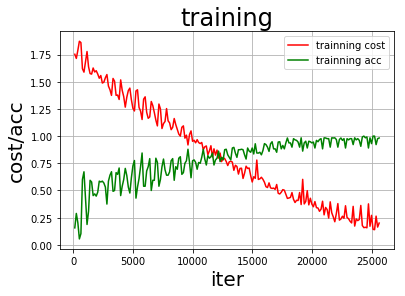

训练模型保存完成！


In [19]:
# 训练的轮数
EPOCH_NUM =40
print('开始训练...')
#两种方法，用两个不同的路径分别保存训练的模型
# model_save_dir = "/home/aistudio/data/model_vgg"
model_save_dir = "/home/aistudio/data/model_cnn"
for pass_id in range(EPOCH_NUM):
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):                         #遍历train_reader的迭代器，并为数据加上索引batch_id
        train_cost, train_acc = exe.run(
            program=fluid.default_main_program(),                            #运行主程序
            feed=feeder.feed(data),                                          #喂入一个batch的数据
            fetch_list=[avg_cost, accuracy])                                 #fetch均方误差和准确率
        
        all_train_iter=all_train_iter+BATCH_SIZE
        all_train_iters.append(all_train_iter)
        all_train_costs.append(train_cost[0])
        all_train_accs.append(train_acc[0])
       
       
        if batch_id % 10 == 0:                                               #每10次batch打印一次训练、进行一次测试
            print("\nPass %d, Step %d, Cost %f, Acc %f" % 
            (pass_id, batch_id, train_cost[0], train_acc[0]))
    # 开始测试
    test_accs = []                                                            #测试的损失值
    test_costs = []                                                           #测试的准确率
    # 每训练一轮 进行一次测试
    for batch_id, data in enumerate(test_reader()):                           # 遍历test_reader
         test_cost, test_acc = exe.run(program=fluid.default_main_program(),  # #运行测试主程序
                                       feed=feeder.feed(data),                #喂入一个batch的数据
                                       fetch_list=[avg_cost, accuracy])       #fetch均方误差、准确率
         test_accs.append(test_acc[0])                                        #记录每个batch的误差
         test_costs.append(test_cost[0])                                      #记录每个batch的准确率

   # 求测试结果的平均值
    test_cost = (sum(test_costs) / len(test_costs))                           # 每轮的平均误差
    test_acc = (sum(test_accs) / len(test_accs))                              # 每轮的平均准确率
    print('Test:%d, Cost:%0.5f, ACC:%0.5f' % (pass_id, test_cost, test_acc))
    
   
    # 如果保存路径不存在就创建
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    # 保存训练的模型，executor 把所有相关参数保存到 dirname 中
    fluid.io.save_inference_model(dirname=model_save_dir, 
                                    feeded_var_names=["image"],
                                    target_vars=[predict],
                                    executor=exe)
                                    
draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")

print('训练模型保存完成！')

infer_imgs的维度： (1, 3, 100, 100)


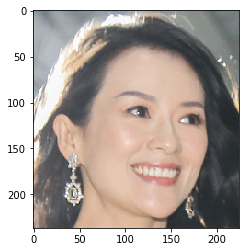

results: 2
[array([[0.23877828, 0.00498002, 0.46040112, 0.0875008 , 0.13402992,
        0.07430975]], dtype=float32)]
infer results: zhangziyi


In [20]:
# coding:utf-8
import paddle.fluid as fluid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import paddle

# 使用CPU进行训练
place = fluid.CPUPlace()
# 定义一个executor
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()#要想运行一个网络，需要指明它运行所在的域，确切的说： exe.Run(&scope) 
#选择保存不同的训练模型
params_dirname ="/home/aistudio/data/model_cnn"
# params_dirname ='/home/aistudio/data/model_vgg'

# （1）图片预处理
def load_image(path):
    img = paddle.dataset.image.load_and_transform(path,100,100, False).astype('float32')#img.shape是(3, 100, 100)
    img = img / 255.0 
    return img

infer_imgs = []
# 选择不同的图片进行预测
infer_imgs.append(load_image('/home/aistudio/images/face/zhangziyi/20181206132141.png'))
# infer_imgs.append(load_image('/home/aistudio/images/face/pengyuyan/20181206161312.png'))
# infer_imgs.append(load_image('/home/aistudio/images/face/jiangwen/0acb8d12-f929-11e8-ac67-005056c00008.jpg'))
# infer_imgs.append(load_image('/home/aistudio/images/face/qianfang/13.jpg'))
infer_imgs = np.array(infer_imgs)
print('infer_imgs的维度：',infer_imgs .shape)

#fluid.scope_guard修改全局/默认作用域（scope）, 运行时中的所有变量都将分配给新的scope
with fluid.scope_guard(inference_scope):
     #获取训练好的模型
    #从指定目录中加载 推理model(inference model)
    [inference_program,# 预测用的program
     feed_target_names,# 是一个str列表，它包含需要在推理 Program 中提供数据的变量的名称。
     fetch_targets] = fluid.io.load_inference_model(params_dirname, infer_exe)#fetch_targets：是一个 Variable 列表，从中我们可以得到推断结果。

    img = Image.open('/home/aistudio/images/face/zhangziyi/20181206132141.png')
    # img = Image.open('/home/aistudio/images/face/pengyuyan/20181206161312.png')
    # img = Image.open('/home/aistudio/images/face/jiangwen/0acb8d12-f929-11e8-ac67-005056c00008.jpg')
    # img = Image.open('/home/aistudio/images/face/qianfang/13.jpg')
    plt.imshow(img)   #根据数组绘制图像
    plt.show()        #显示图像

    # 开始预测
    results = infer_exe.run(
        inference_program,                      #运行预测程序
        feed={feed_target_names[0]: infer_imgs},#喂入要预测的数据
        fetch_list=fetch_targets)               #得到推测结果
    print('results:',np.argmax(results[0]))

    # 训练数据的标签
    label_list = ["zhengkai","dilireba","zhangziyi","pengyuyan","jiangwen","tangqi"]
    print(results)
    print("infer results: %s" % label_list[np.argmax(results[0])])